<a href="https://colab.research.google.com/github/AdamCorbinFAUPhD/Fairness/blob/main/isic_2017/2022_05_18/ITA_ISIC2017_8x8_4%25border.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TESTING ISIC 2017 8x8 4% border removal






# Overview

This Google colab will go over different approaches to computing the Fitzpatrick skin tone types. Having the skin types will allow for datasets and machine learning models to be evaluated for fairness. Its imporant  The Fitzpatrick ranges are in table 1. The Goth ranges are in table 2 from this [paper]( https://arxiv.org/abs/2104.09957)


### Table 1 Fitzpatrick ranges

|ITA Range| Skin Tone Category|
|--|--|
|55$^\circ <$ ITA | Type1|
|41$^\circ<$ ITA $\leq$ 55$^\circ$|Type2|
|28$^\circ<$ ITA $\leq$ 41$^\circ$|Type3|
|19$^\circ<$ ITA $\leq$ 28$^\circ$|Type4|
|10$^\circ<$ ITA $\leq$ 19$^\circ$|Type5|
|ITA $\leq$ 10$^\circ$|Type6|

### Table 2 Goth ranges

|ITA Range| Skin Tone Category|
|--|--|
|40$^\circ <$ ITA | Type1|
|23$^\circ<$ ITA $\leq$ 40$^\circ$|Type2|
|12$^\circ<$ ITA $\leq$ 23$^\circ$|Type3|
|0$^\circ<$ ITA $\leq$ 12$^\circ$|Type4|
|-25$^\circ<$ ITA $\leq$ 0$^\circ$|Type5|
|ITA $\leq$ -25$^\circ$|Type6|

Figure 1 gives an overview of the pipeline of this colab. One of the 3 data sets are selected. There is some pre-processing of images to organize them into data frames. Then all 4 different approaches along with the ground truth compute the ITA value of the image. 

The main 5 appraches that are as follows
1. Masked image - Ground truth
2. Full image 
3. Center Cropped
4. Structured Patches
5. Random Patches

The ITA uses the following equation

ITA$ = archtan \left(\frac{L - 50}{b} \right) \times \frac{180^\circ}{\pi}$

where $L$ is luminance and $b$ is amount of blue/yellow

The approaches that use patches will take a median of the list of ITA values computed for the individual image. Once the ITA values have been computed the ITA category is translated from both table 1 and table 2. The metrics evaluation phase occurs where the ITA estimate is compared to the ground truth computation. Also the skin tone classes are compared to the ground truth classes for both table 1 and table 2. The final metrics comparison groups images based on the size of the lesion relative to the image size to see how much the lesion size affects the performance on the approaches.


### Figure 1 Pipeline overiew 
![](https://i.imgur.com/kYysOvR.png)


# Setup & Get images

## Constants 

In [1]:
%%time
BORDER_REMOVAL_SIZE = .04  # Going to trim %4 of the sides
PATCH_WIDTH = 8  # Its recommended to pick patch size that can be a multiple of 8 because of the images usually a multiple of 8
PATCH_HEIGHT = PATCH_WIDTH
PERCENTAGE_OF_RANDOM_PATCHES = .20
PERCENTAGE_OF_RANDOM_PATCHES_NAME = int(PERCENTAGE_OF_RANDOM_PATCHES*100)
TEST_RANDOM_PATCH_PERCENTAGE = False
PERCENTAGE_OF_RANDOM_ENTROPY_SELECTED_PATCHES = .20
PERCENTAGE_OF_RANDOM_ENTROPY_SELECTED_PATCHES_NAME = int(PERCENTAGE_OF_RANDOM_ENTROPY_SELECTED_PATCHES*100)

DATASET_USED = "ISIC_2017" ## options ISIC_2016, ISIC_2017, ISIC_2018

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 11.4 µs


## Installs & Imports

### install

In [2]:
%%time
!pip install patchify
!pip uninstall scikit-learn -y
!pip install -U scikit-learn
!pip install swifter
!pip install line_profiler

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
     |████████████████████████████████| 24.8 MB 1.2 MB/s 
     |████████████████████████████████| 647 kB 4.2 MB/s 
     |████████████████████████████████| 280 kB 44.0 MB/s 
     |████████████████████████████████| 136 kB 51.1 MB/s 
  Created wheel for swifter: filename=swifter-1.1.3-py3-none-any.whl size=13078 sha256=16fb6ee1b89a83d9bebf30bb5d662a0e02360e65e4a1d70ddf9c0e634aea6211
  Stored in directory: /root/.cache/pip/wheels/e8/1a/1b/46aa7b0fac16d3ce1bccaac14bfe4fad972642217ae78d8160
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


     |████████████████████████████████| 67 kB 2.5 MB/s 
CPU times: user 394 ms, sys: 100 ms, total: 494 ms
Wall time: 26.5 s


### Imports

In [3]:
%%time
import random
import os
import io
import json
import numpy as np 
import pandas as pd 
import seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.patches as mplpatches
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, explained_variance_score, mean_squared_log_error
from sklearn.metrics import r2_score, mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage.io import imread
from scipy.interpolate import BSpline, make_interp_spline
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d

import swifter

from patchify import patchify
from pathlib import Path

import tensorflow as tf, re, math
import tensorflow.keras.backend as K

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from skimage.util.shape import view_as_windows
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import skimage
import cv2
from skimage import color
import bottleneck as bn  # Has some faster math functions than numpy: https://github.com/pydata/bottleneck


AUTO = tf.data.experimental.AUTOTUNE
random.seed(42)
rng = np.random.default_rng(seed=42)

CPU times: user 4.55 s, sys: 844 ms, total: 5.39 s
Wall time: 6.63 s


In [4]:
%load_ext line_profiler

## Datasets - Download Images

This section is responsible for downloading the selected dataset. If you want to change the dataset update the DATASET_USED constant in the constants section.

These datasets were chosen because they have masks around the skin lesion which is used for the ground truth.

All of these datasets can be found here: https://challenge.isic-archive.com/data/

### ISIC 2016 Task 1 training and test data

In [5]:
%%time
if DATASET_USED == "ISIC_2016":
    !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip
    !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_Data.zip
    !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip
    !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_GroundTruth.zip

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


In [6]:
%%time
if DATASET_USED == "ISIC_2016":
    !unzip ISBI2016_ISIC_Part1_Training_Data.zip -d ISIC_2016 > /dev/null.
    !unzip ISBI2016_ISIC_Part1_Test_Data.zip -d ISIC_2016 > /dev/null.
    !unzip ISBI2016_ISIC_Part1_Training_GroundTruth.zip -d ISIC_2016_GT > /dev/null.
    !unzip ISBI2016_ISIC_Part1_Test_GroundTruth.zip -d ISIC_2016_GT > /dev/null.

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.2 µs


In [7]:
%%time
if DATASET_USED == "ISIC_2016":
    # Display both 1 mask and 1 regular file
    index = 0
    files = Path("ISIC_2016").glob("**/*.jpg")
    org = ""
    org_files = []
    for file in files:
        org_files.append(file)
        
    org_files.sort()
    print(org_files[index])
    org = Image.open(org_files[index])
        
    gt_files = Path("ISIC_2016_GT").glob("**/*.png")
    gt = ""
    gt_files_list = []
    for file in gt_files:
        gt_files_list.append(file)
        
    gt_files_list.sort()    
    print(gt_files_list[index])
    gt = Image.open(gt_files_list[index])

    ax = plt.subplot(1, 2, 1)

    plt.imshow(org,aspect=.7)
    plt.title("Original image")
    plt.axis("off")
    plt.subplots_adjust(hspace = .5)

    ax = plt.subplot(1, 2,2)

    plt.imshow(gt,aspect=.7)
    plt.title("Masked Image")
    plt.axis("off")
    plt.subplots_adjust(hspace = .5)

    print(f"Same size? {len(org_files) == len(gt_files_list)} {len(org_files)}")

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


### ISIC 2017 dataset
This includes the training, validation, and test data resised to 192 x 256. 

In [8]:
%%time
if DATASET_USED == "ISIC_2017":
    !git clone https://github.com/manideep2510/melanoma_segmentation.git

Cloning into 'melanoma_segmentation'...
remote: Enumerating objects: 5578, done.
remote: Total 5578 (delta 0), reused 0 (delta 0), pack-reused 5578
Receiving objects: 100% (5578/5578), 101.46 MiB | 42.12 MiB/s, done.
Resolving deltas: 100% (464/464), done.
Checking out files: 100% (5509/5509), done.
CPU times: user 75.7 ms, sys: 28.4 ms, total: 104 ms
Wall time: 4.96 s


### ISIC 2018
https://challenge.isic-archive.com/data

In [9]:
%%time
if DATASET_USED == "ISIC_2018":
    !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
    !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.54 µs


In [10]:
%%time
if DATASET_USED == "ISIC_2018":
    !unzip ISIC2018_Task1-2_Training_Input.zip -d ISIC_2018 > /dev/null.
    !unzip ISIC2018_Task1_Training_GroundTruth.zip -d ISIC_2018_GT > /dev/null.

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 10.5 µs


# Organize images into a dataset

This sections the images and the inverted makses are inserted into a dataframe. The Panadas dataframe will be used to keep track of all data generated such as ITA values or skin lesion precentage 

## Read all image paths

In [91]:
%%time
"""
This section we read all the images including their masks. 
"""

orig_images = []
masks_images = []

if DATASET_USED == "ISIC_2016":
    for file in Path("ISIC_2016").glob("**/*.jpg"):        
        orig_images.append(file)

    for file in Path("ISIC_2016_GT").glob("**/*.png"):
        masks_images.append(file)

if DATASET_USED == "ISIC_2017":
    """ Since we are just using this to test the ITA values we can join 
        the test, train and validation sets
    """
    folders_to_search = ["test","train","validation"]
    for folder in folders_to_search:
        for file in Path(f"melanoma_segmentation/{folder}x").glob("*.jpg"):        
            orig_images.append(file)

        for file in Path(f"melanoma_segmentation/{folder}y").glob("*.jpg"):
            masks_images.append(file)

if DATASET_USED == "ISIC_2018":
    for file in Path("ISIC_2018").glob("**/*.jpg"):        
        orig_images.append(file)

    for file in Path("ISIC_2018_GT").glob("**/*.png"):
        masks_images.append(file)

print(len(orig_images))
print(len(masks_images))


2750
2750
CPU times: user 19.7 ms, sys: 4.01 ms, total: 23.7 ms
Wall time: 23.7 ms


In [92]:
def strip_filename(file):
    """
    This function makes an identifier that matches between both the base image and the masked image
    """
    if DATASET_USED == "ISIC_2017":
        # Cleaning files names here: https://github.com/manideep2510/melanoma_segmentation.git
        fn = file.name.replace("imgx","")
        fn = fn.replace("imgy","")
        path = file.parent.parts[-1].replace("x","").replace("y","")

    # Cleaning ISIC 2016 filenames
    if DATASET_USED == "ISIC_2016":
        fn = file.name.replace("_Segmentation","").replace(".jpg","").replace(".png","")
        path = file.parent.parts[-1].replace("_Data","").replace("_GroundTruth","")

    if DATASET_USED == "ISIC_2018":
        fn = file.name.replace("_segmentation","").replace(".jpg","").replace(".png","")
        path = file.parent.parts[-1].replace("-2_Training_Input","").replace("_Training_GroundTruth","")
    
    uuid = f"{path}/{fn}"
    return uuid

In [93]:
def create_masked_image(image, mask):
    """
    This function takes in an image and mask in bytes. Since the mask is intended to be used to selected the
    skin lesion we need to invert the mask so we can remove the skin lesion. Once invert, the mask is applied the
    original image and then the new masked_image is return as a byte array.
    """
    
    orig_image = Image.open(io.BytesIO(image))
    
    imgpx = np.array(orig_image)

    mask_bytes = io.BytesIO(mask)
    mask = Image.open(mask_bytes)
    mask = ImageOps.invert(mask) # need to invert the mask because we want to only remove the skin lesion 
    mask_pix = np.array(mask)    

    # Adding the mask to the image 
    image_masked = np.where(mask_pix[...,None], imgpx,0)
    im_byte_array = Image.fromarray(image_masked)

    # Saving the masked image to a byte array
    img_byte_arr = io.BytesIO()
    orig_image = im_byte_array.convert('RGB')
    orig_image.save(img_byte_arr, format="JPEG")
    img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr

## Create dataframe with images and masks

In [94]:
%%time
dict_data = {}
data_list = []
for file in orig_images:    
    dict_data[strip_filename(file)] = file

for file in masks_images:
    
    # Adding the previous image to the new item so it will include both mask and image    
    image = open(dict_data[strip_filename(file)],"rb").read()    
    mask = open(file,"rb").read()

    # now to cut the mask out of the image
    masked_image = create_masked_image(image, mask)
    data_list.append([strip_filename(file), image, mask, masked_image ])
    

# now to create the dataframe
df = pd.DataFrame(data=data_list, columns=["ID","image", "mask", "masked_image"])

CPU times: user 9.74 s, sys: 257 ms, total: 10 s
Wall time: 9.97 s


### Compute the masked percentage of the whole image

In [95]:
def compute_mask_percentage(row):
    mask_array = np.array(Image.open(io.BytesIO(row["mask"])))    
    total = mask_array.size
    mask_count = np.count_nonzero(mask_array)

    percentage = mask_count / total
    row["mask_percentage"] = math.ceil(percentage * 100)
    return row

In [96]:
%%time
df = df.swifter.apply(compute_mask_percentage, axis=1)


Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

CPU times: user 3.19 s, sys: 20 ms, total: 3.21 s
Wall time: 3.17 s


In [97]:
def display_image_with_mask(item):
    print(item)
    mask = item["mask"]
    image = item["image"]
    img = io.BytesIO(mask)
    mask = Image.open(img)
    mask = ImageOps.invert(mask) # need to invert the mask because we want to only remove the skin lesion 

    orig_image = Image.open(io.BytesIO(image))
    pix = np.array(mask)
    imgpx = np.array(orig_image)
    image_masked = np.where(pix[...,None], imgpx,0)
    print("Shape of image: ", imgpx.shape)

    im = Image.fromarray(image_masked)


    ax = plt.subplot(1, 2, 1)
    image = Image.open(io.BytesIO(item["image"]))
    plt.imshow(image,aspect=.7)
    plt.title("Original image")
    plt.axis("off")
    plt.subplots_adjust(hspace = .5)

    ax = plt.subplot(1, 2,2)
    image = Image.open(io.BytesIO(item["masked_image"]))
    plt.imshow(image,aspect=.7)
    plt.title("Masked Image")
    plt.axis("off")
    plt.subplots_adjust(hspace = .5)

### Looking at high percentage masks

ID                                                      test/328.jpg
image              b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
mask               b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
masked_image       b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
mask_percentage                                                   98
Name: 271, dtype: object
Shape of image:  (192, 256, 3)


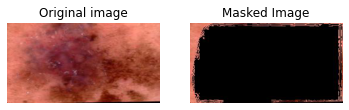

In [98]:
percentage_list = list(df.mask_percentage.unique())
percentage_list.sort()
high_percentage = percentage_list[-1]
high_percentage_item = df[df.mask_percentage == high_percentage]
high_percentage_item

index = 0
item = high_percentage_item.iloc[index] 
display_image_with_mask(item)

### Display dataframe item and images

Sample just 1 image to display the original and original with the masked lesion removed. 

ID                                                        test/1.jpg
image              b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
mask               b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
masked_image       b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
mask_percentage                                                   53
Name: 0, dtype: object
Shape of image:  (192, 256, 3)
CPU times: user 41.8 ms, sys: 2.94 ms, total: 44.7 ms
Wall time: 41.5 ms


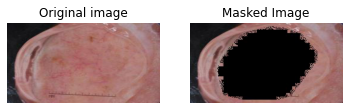

In [99]:
%%time
index = 0
item = df.iloc[index] 
display_image_with_mask(item)


## Evaluate image sizes

In [100]:
# This section looks at each image forthe size and keeps track of the count
shapes = {}
for item in df.iterrows():
    # print(item)
    orig_image = Image.open(io.BytesIO(item[1]["image"]))
    pix = np.array(mask)
    imgpx = np.array(orig_image)
    if str(imgpx.shape) in shapes:
        shapes[str(imgpx.shape)] += 1
    else:
        shapes[str(imgpx.shape)] = 1

In [101]:
print(json.dumps(shapes, indent=4))

{
    "(192, 256, 3)": 2750
}


<BarContainer object of 1 artists>

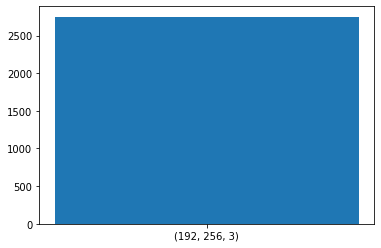

In [102]:
# showing bar graph of all the different sizes of images
plt.bar(list(shapes.keys()),list(shapes.values()))

#### Compute min and max image sizes

In [103]:
# compute min, max
min = math.inf
min_dimensions = ""
max = 0
max_dimensions = ""
total_width = 0
total_height = 0
total_count = 0
for key, count in shapes.items():
    split_string = key.strip("(").strip(")").split(",")
    height = int(split_string[0])
    width = int(split_string[1])
    total_width += width * count
    total_height += height * count
    total_count += count
    pixel_count = height * width
    if pixel_count < min:
        min = pixel_count
        min_dimensions = key
    if pixel_count > max:
        max = pixel_count
        max_dimensions = key

average_width = total_width / total_count
average_height = total_height / total_count
print(f"Max Dimensions {max_dimensions}")
print(f"Min Dimensions {min_dimensions}")

print(f"Average dimensions ({average_height},{average_width})")


Max Dimensions (192, 256, 3)
Min Dimensions (192, 256, 3)
Average dimensions (192.0,256.0)


# ITA experiments

This section sets up all the differnt appraches and tests each apprach on an an image. 

**Note** - Each image has the boarder trimmed by 4% to help remove the dark corners that are typical in dermoscopic images. Leaving in these black corners will affect the computation of the ITA value. Preliminary test showed that 4% was the best value where it removed the dark corners but didn’t remove too many pixels of the skin.

#### Compute border removal amount

In [104]:
def get_border_removal_size(image):
    """
    This function will compute the border removal size based on the width of the image as well as depending on the patch
    size to insure that the patches will covert the full image
    """
    w, h = image.size
    return int(math.ceil(w * BORDER_REMOVAL_SIZE / PATCH_WIDTH)) * PATCH_WIDTH


In [105]:
def trim_boarder_from_image(pil_image):
    """
    This function will take an image, remove the boarder and return the cropped image.
    """
    w, h = pil_image.size
    removal_size = get_border_removal_size(pil_image)
    cropped_area = (removal_size,removal_size,w - removal_size, h - removal_size)
    cropped_image = pil_image.crop(cropped_area)
    return cropped_image

## Preproces images
Each image will be processed to remove the boarder and converted to the lab format

In [106]:
def trim_boarder_and_convert_to_lab(image):
    """
    This function takes in an image, removes the boarder, converts to lab, and returns
    the lab value of the image

    There is an option to remove the boarder that is used to remove the back corners.  
    """
    img = io.BytesIO(image)
    pilimae = Image.open(img)  
    
    w, h = pilimae.size
    removal_size = get_border_removal_size(pilimae)
    cropped_area = (removal_size,removal_size,w - removal_size, h - removal_size)
    pilimae = pilimae.crop(cropped_area)      

    
    lab = np.array(skimage.color.rgb2lab(pilimae))
    
    return lab

In [107]:
%%time
df["image_trimmed_and_lab_format"] = df["image"].swifter.apply(trim_boarder_and_convert_to_lab)

Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

CPU times: user 47.5 s, sys: 2.7 s, total: 50.2 s
Wall time: 49.6 s


In [108]:
%%time
df["masked_image_trimmed_and_lab_format"] = df["image"].swifter.apply(trim_boarder_and_convert_to_lab)

Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

CPU times: user 50.1 s, sys: 6.06 s, total: 56.1 s
Wall time: 55.6 s


## Compute the ITA value for each image

This section is a simple ITA computation on the images that are masked and unmasked

In [166]:
def compute_ita_from_lab(lab):
    """
    This function computes the ITA value of the image along with ignore any pixels that are completly black
    """
    # get the luminance and b values wihtin +- 1 std from mean
    l = lab[:,:,0]
    # l = np.where(l != 0, l, np.nan)
    l[l == 0] = np.nan
    
    std = bn.nanstd(l)
    mean = bn.nanmean(l)
    
    l = np.where(l >= mean - std, l, np.nan)
    #l[l < mean - std] = np.nan
    
        
    l = np.where(l <= mean + std, l, np.nan)
    #l[l > mean + std] = np.nan
    
    b = lab[:,:,2]
    std = bn.nanstd(b)
    mean = bn.nanmean(b)

    b = np.where(b >= mean - std, b, np.nan)
    #b[b < mean - std] = np.nan
    

    b = np.where(b <= mean + std, b, np.nan)
    #b[b > mean + std] = np.nan
    
    ita = math.atan2(bn.nanmean(l) - 50, bn.nanmean(b)) * (180 / np.pi)
    return ita

In [110]:
def compute_ita(lab, crop_border=False):
    """
    This function takes in an image and outputs the ITA value of image. To compute the ITA value the image needs 
    to be converted from an RGB format to a LAB format type. 

    There is an option to remove the boarder that is used to remove the back corners.  
    """
    img = io.BytesIO(image)
    pilimae = Image.open(img)  

    if crop_border:
        w, h = pilimae.size
        removal_size = get_border_removal_size(pilimae)
        cropped_area = (removal_size,removal_size,w - removal_size, h - removal_size)
        pilimae = pilimae.crop(cropped_area)      

    
    lab = np.array(skimage.color.rgb2lab(pilimae))
    return compute_ita_from_lab(lab)


### Compute the ITA of the original image

In [ ]:
%%time
df["ITA_orig"] = df["image"].swifter.apply(compute_ita,crop_border=True)

In [ ]:
#%%time
#df["ITA_orig"] = df["image_trimmed_and_lab_format"].swifter.apply(compute_ita_from_lab)

In [ ]:
#df["image"].head()

In [ ]:
#df["ITA_orig_new"].head()

In [ ]:
#df["ITA_orig"].equals(df["ITA_orig_new"])

In [168]:
%%time
df["ITA_orig"] = df["image_trimmed_and_lab_format"].swifter.apply(compute_ita_from_lab)

Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

CPU times: user 5.17 s, sys: 91.7 ms, total: 5.27 s
Wall time: 5.23 s


### Compute the ITA of the masked image

In [169]:
%%time
df["ITA_masked"] = df["masked_image_trimmed_and_lab_format"].swifter.apply(compute_ita_from_lab)

Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

CPU times: user 4.44 s, sys: 78 ms, total: 4.52 s
Wall time: 4.47 s


In [170]:
df["ITA_masked"] 

0       23.538748
1       17.275617
2       21.397060
3       65.354506
4       37.149207
          ...    
2745    86.560070
2746    66.508627
2747    48.769187
2748    35.977086
2749    46.612053
Name: ITA_masked, Length: 2750, dtype: float64

##Patches experiments

 ### Utils

#### Creating patches from an image


In [171]:
def format_image_and_get_patches(image):
    """
    This function will remove the 4% boarder, convert the whole image from RGB to LAB and then using Patchify 
    tool it will create patches. These patches are non-overlapping that create a grid over the whole image. 
    The image sizes are defined from the Constants section.
    """
    img = io.BytesIO(image)
    pil_image = Image.open(img) 

    # Crop image to remove the pixels from the boarder
    w, h = pil_image.size
    removal_size = get_border_removal_size(pil_image)
    cropped_area = (removal_size,removal_size,w - removal_size, h - removal_size)
    cropped_image = pil_image.crop(cropped_area)


    #print("pil_image", np.array(pil_image).shape)
    #print("cropped_image", np.array(cropped_image).shape)
    # Convert image to lab values
    lab = np.array(skimage.color.rgb2lab(cropped_image))

    # Get the patches
    return patchify(lab, (PATCH_WIDTH,PATCH_HEIGHT,3), step=PATCH_WIDTH)

In [172]:
def get_patches(lab):
    """
    using Patchify tool it will create patches. These patches are non-overlapping that create a grid over the whole image. 
    The image sizes are defined from the Constants section.
    """

    # Get the patches
    return patchify(lab, (PATCH_WIDTH,PATCH_HEIGHT,3), step=PATCH_WIDTH)

#### Display 1 image with the selected patches

In [173]:
def display_single_image_and_selected_patches(image_in_bytes, selected_coords):
    """
    This function will take the image that is stored in bytes along with the indexes of the patches that are selected. 
    The image gets displayed and then the selected patches will be outlined to show which were the 
    key patches in the ITA calculation. 
    """
    img = io.BytesIO(image_in_bytes)

    im = Image.open(img)

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(im)

    removal_size = get_border_removal_size(im)
    print("removal size", removal_size)

    for coord in selected_coords:
        # Create a Rectangle patch    
        x = coord[0] * PATCH_WIDTH + removal_size
        y = int(coord[1] * PATCH_WIDTH) + removal_size    
        rect = mplpatches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

### ITA on all patches
This section will get the ITA value for all patches within a given image

In [174]:
def get_ita_for_all_patches(image):
    """
    This function will take the whole image, break up the image into patches and compute the ITA value for each patch. 
    """
    patches = get_patches(image)
    # Capture all the ITA values for each patch. 
    ita_values = []
    indices = []
    for x, x_item in enumerate(patches):
        for y, y_item in enumerate(patches[x]):        
            patch = patches[x][y][0]        
            ita_values.append(compute_ita_from_lab(patch))  
            indices.append([x,y])
    # dropping any nan computed values            
    ita_values = [x for x in ita_values if math.isnan(x) == False]
    return ita_values, indices

#### Test 1 image

removal size 16


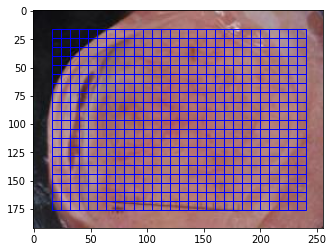

CPU times: user 923 ms, sys: 9.08 ms, total: 932 ms
Wall time: 922 ms


In [175]:
%%time
full_image_ita, full_image_coords = get_ita_for_all_patches(df.iloc[0]["image_trimmed_and_lab_format"])
display_single_image_and_selected_patches(df.iloc[0]["image"],full_image_coords)

### Center Cropped

In [176]:
def get_cropped_center_patches_ita_list(image, verbose=False):
    """
    For the structure patches approach the first row, the last row, first column and last column will be 
    sampled for the ITA values.
    """
    """
    Note we want to ignore the center part of the images. We will take 15% around the center of the image and ignore getting the ITA
    values for those images. Taking 15% of the width and height will get offset value. Then dividing the width and height by 2
    will be the mid-point which we can take the offset and do a +- to get a range where we dont want to capture the ITA values
    as long as the x and y indexes dont fall between both ranges then we will capture the ITA values of the image.

    """
    patches = get_patches(image)

    center_removal_percentage = .70/2
    h = len(patches)
    w = len(patches[0])

    w_offset = math.floor(w * center_removal_percentage)
    h_offset = math.floor(h * center_removal_percentage)

    w_mid = int(w/2)
    h_mid = int(h/2)

    indices = []

    if verbose:
        print("Will ignore values in these ranges")
        print("center_removal_percentage",center_removal_percentage)
        print("w",w)
        print("h",h)
        print("w_offset",w_offset)
        print("h_offset",h_offset)
        print("w_mid",w_mid)
        print("h_mid",h_mid)
        w_range = (w_mid + w_offset) - (w_mid - w_offset)
        print(f"w range diff {w_range} : % {w_range/w}")
        h_range = (h_mid + h_offset) - (h_mid - h_offset)
        print(f"h range diff {h_range} : %{h_range/h}")
        print(f"{w_mid - w_offset} <= x < {w_mid + w_offset} and {h_mid - h_offset} <= y < {h_mid + h_offset}")
    selected_ita_values = []
    for y, y_item in enumerate(patches):
        for x, x_item in enumerate(patches[y]):
            if w_mid - w_offset <= x < w_mid + w_offset and h_mid - h_offset <= y < h_mid + h_offset:
                continue
            patch = patches[y][x][0]        
            selected_ita_values.append(compute_ita_from_lab(patch)) 
            indices.append([y,x])
    
    return selected_ita_values, indices

In [177]:
def get_cropped_center_ita(row):
    """
    This is the wrapper function to calculate the ITA values for all the patches, the median ITA value and 
    stores all the patch indices for each Image of the dataset.
    """
    image = row["image_trimmed_and_lab_format"]
    ita_values, indices = get_cropped_center_patches_ita_list(image)
    # dropping any nan computed values            
    ita_values = [x for x in ita_values if math.isnan(x) == False]
    row["ITA_center_cropped_all"] = ita_values
    row["ITA_center_cropped"] = np.median(ita_values)
    row["ITA_center_cropped_indices"] = indices
    return row 

#### Test 1 image

Will ignore values in these ranges
center_removal_percentage 0.35
w 28
h 20
w_offset 9
h_offset 7
w_mid 14
h_mid 10
w range diff 18 : % 0.6428571428571429
h range diff 14 : %0.7
5 <= x < 23 and 3 <= y < 17
removal size 16


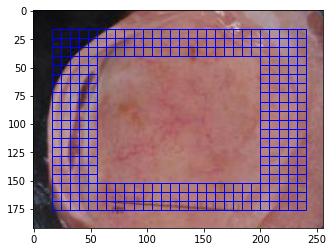

308 560 0.55
CPU times: user 569 ms, sys: 21.1 ms, total: 590 ms
Wall time: 578 ms


In [178]:
%%time
ita, cropped_center_coords = get_cropped_center_patches_ita_list(df.iloc[0]["image_trimmed_and_lab_format"], verbose=True)
display_single_image_and_selected_patches(df.iloc[0]["image"],cropped_center_coords)
print(len(cropped_center_coords), len(full_image_coords), len(cropped_center_coords)/ len(full_image_coords))

### Structured Patches

Creating masks can be difficult to obtain from either working with medical professionals to generate the masks or even developing an AI segmentation solution to generate the masks. In this alternate approach the idea would be to take small patches around the boarder of the image. The center of the image will not be sampled as we are assuming that skin lesion will be around that potion of the image. Also the absolute boarder will be also ignored with an assumption that there might be some bad artifacts around the boarder that would not represent the skin tones.

In [179]:
def get_structured_patches_ita_list(image):
    """
    For the structure patches approach the first row, the last row, first column and last column will be 
    sampled for the ITA values. When taking the boarder we need ot make sure the corners are not double counted
    """
    patches = get_patches(image)

    selected_ita_values = []

    row_count = len(patches)
    col_count = len(patches[0])
    

    indices = []
    # First row
    for i, patch in enumerate(patches[0]):        
        selected_ita_values.append(compute_ita_from_lab(patch[0])) 
        indices.append([0,i])
    # last row
    for i, patch in enumerate(patches[-1]):        
        selected_ita_values.append(compute_ita_from_lab(patch[0])) 
        indices.append([row_count - 1,i])
    # First column
    # Not index zero and last index is a corner and already accounted for on the rows
    for i in range(1,row_count - 1):
        patch = patches[i][0]
        selected_ita_values.append(compute_ita_from_lab(patch[0])) 
        indices.append([i,0])

    # Last column
    # Not index zero and last index is a corner and already accounted for on the rows
    for i in range(1,row_count - 1):
        patch = patches[i][-1]
        selected_ita_values.append(compute_ita_from_lab(patch[0]))
        indices.append([i,col_count-1])


    return selected_ita_values, indices

In [180]:
def get_structured_patches_ita(row):
    """
    This function is intended to add the ITA represented value dataframe for an instance. 
    Its intended to be used with the df.swifter.apply() method
    """
    image = row["image_trimmed_and_lab_format"]
    ita_values, indices = get_structured_patches_ita_list(image)
    # dropping any nan computed values            
    ita_values = [x for x in ita_values if math.isnan(x) == False]
    row["ITA_structured_patches_all"] = ita_values
    row["ITA_structured_patches"] = np.median(ita_values)
    row["ITA_structured_patches_indices"] = indices

    return row

#### Testing 1 image

removal size 16


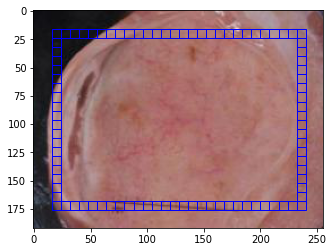

CPU times: user 328 ms, sys: 4.17 ms, total: 333 ms
Wall time: 325 ms


In [181]:
%%time
%lprun -f get_structured_patches_ita -f get_structured_patches_ita_list -f format_image_and_get_patches -f compute_ita_from_lab ita, coords = get_structured_patches_ita_list(df.iloc[0]["image_trimmed_and_lab_format"])
display_single_image_and_selected_patches(df.iloc[0]["image"],coords)

### Random patches

In [182]:
# randomly pick numbers between 0 and max patches
def get_random_patches_ita_list(image,percentage=PERCENTAGE_OF_RANDOM_PATCHES, verbose=False):
    """
    The premise behind random patches is that a set of patches that do not overlap a generated and at random patches 
    be sampled to take the ITA value from. The thought would be that because its a random sample that the majority should
    cover or represent the skin tone. It is possible that some of the patches could cover a skin lesion which will be address in 
    a future approach.
    """
    patches = get_patches(image)
    row_count = len(patches)
    column_count = len(patches[0])
    
    patch_count = row_count * column_count
    
    random_to_select = int(patch_count * percentage)
    
    # Generate a random list of numbers with no duplicates
    random_patch_indexes = rng.choice(patch_count, size=random_to_select, replace=False)
    random_patch_indexes.sort()
    
    # get reverse indexes. The index number comes from nRow * col_count + nCol. 
    # so for example if you have 10x10 image. image index 23 is row 2 col 4. The formula would be 2*10 + 4 = 24
    # x = number % column_count
    # y = int(number / column_count) 
    
    coordinate_indices = []
    for index in random_patch_indexes:
        y = index % column_count
        x = int(index /column_count)
        coordinate_indices.append([x,y])
    if verbose:
        print(f"row_count {row_count} column_count {column_count} ")
        print(f"patch_count {patch_count}, random_to_select {random_to_select}")
        #print(f"random_patch_indexes\n{random_patch_indexes}")
        #print(f"coordinate_indices\n{coordinate_indices}")

    ita_values = []
    for index in coordinate_indices:
        x = index[1]
        y = index[0]
        patch = patches[y][x]
        ita_values.append(compute_ita_from_lab(patch[0]))
    # dropping any nan computed values            
    ita_values = [x for x in ita_values if math.isnan(x) == False]
    return ita_values, coordinate_indices



In [183]:
def get_random_patches_ita(row,percentage=PERCENTAGE_OF_RANDOM_PATCHES):
    """
    This function is intended to add the ITA represented value dataframe for an instance. 
    Its intended to be used with the df.swifter.apply() method
    """

    image = row["image_trimmed_and_lab_format"]
    
    ita_values, indices = get_random_patches_ita_list(image, percentage)
    row[f"ITA_random_patches_{int(percentage*100)}_all"] = ita_values
    row[f"ITA_random_patches_{int(percentage*100)}"] = np.median(ita_values)
    row[f"ITA_random_patches_{int(percentage*100)}_indices"] = indices
    return row

#### Testing 1 image

row_count 20 column_count 28 
patch_count 560, random_to_select 112
removal size 16


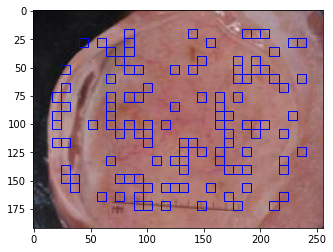

CPU times: user 334 ms, sys: 10.2 ms, total: 345 ms
Wall time: 334 ms


In [184]:
%%time
ita, coords = get_random_patches_ita_list(df.iloc[0]["image_trimmed_and_lab_format"],verbose=True)
display_single_image_and_selected_patches(df.iloc[0]["image"],coords)

#### Showing Random 100%

row_count 20 column_count 28 
patch_count 560, random_to_select 560
removal size 16


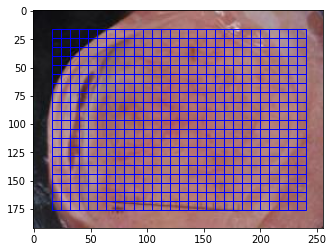

CPU times: user 892 ms, sys: 6.04 ms, total: 898 ms
Wall time: 892 ms


In [185]:
%%time
ita_random_100, coords_random_100 = get_random_patches_ita_list(df.iloc[0]["image_trimmed_and_lab_format"],percentage=1,verbose=True)
display_single_image_and_selected_patches(df.iloc[0]["image"],coords_random_100)

#### Compare Random 100% vs all patches 
Test using the rMSE and MAE between both the full image and random 100%. If they were any different there would have a value greater than 0

In [186]:
rmse = mean_squared_error(full_image_ita, ita_random_100, squared=False)
mae = mean_absolute_error(full_image_ita, ita_random_100)
print("rmse",rmse)
print("mae",mae)


rmse 0.0
mae 0.0


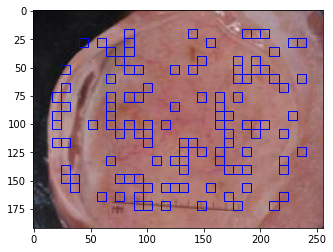

CPU times: user 321 ms, sys: 5.05 ms, total: 326 ms
Wall time: 321 ms


In [187]:
%%time
# display image, 
# add rectangles on each of the patches

img = io.BytesIO(df.iloc[0]["image"])

im = Image.open(img)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)
removal_size = get_border_removal_size(im)
for coord in coords:
    # Create a Rectangle patch    
    x = coord[0] * PATCH_WIDTH + removal_size
    y = int(coord[1] * PATCH_WIDTH) + removal_size
    rect = mplpatches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

#### Test Random Patch percentage
The idea here is to check and see if different percentages work better than others. Starting from 5 percent to 100%

Note – this is not run every time but only when the TEST_RANDOM_PATCH_PERCENTAGE is true. This block of code does take a long time to run

In [188]:
%%time
if TEST_RANDOM_PATCH_PERCENTAGE:
    df_percent  = pd.DataFrame()
    columns_to_test = ["ITA_orig"]
    results = []
    for percent in range(5,101,5):
        col = f"ITA_random_patches_{percent}"
        columns_to_test.append(col)
        # df_percent[f"percent_{percent}"]
        df_percent = df.swifter.apply(get_random_patches_ita, percentage=percent/100,axis=1)
        res = f"{col} {compute_metrics(df_percent,col)}"
        results.append(res)
        print(res)
    
    for res in results:
        print(results)
        
    

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.2 µs


In [189]:
%%time
if TEST_RANDOM_PATCH_PERCENTAGE:
    #results = ["ITA_random_patches_5 {'Root Mean Squared Error': 22.644068119396845, 'Mean Absolute Error': 9.433725404146573, 'Max error': 295.34283795198667, 'Mean Squared Error': 512.7538209958846, 'Explained Variance Score': 0.5116493813766296, 'R^2 Score': 0.4665957747335927}", "ITA_random_patches_10 {'Root Mean Squared Error': 21.517008523395074, 'Mean Absolute Error': 8.947842487466325, 'Max error': 158.57299716134094, 'Mean Squared Error': 462.9816557958562, 'Explained Variance Score': 0.5665311433693841, 'R^2 Score': 0.5182531908526522}", "ITA_random_patches_15 {'Root Mean Squared Error': 21.506358967855427, 'Mean Absolute Error': 8.846049598928758, 'Max error': 202.0117662354209, 'Mean Squared Error': 462.5234760542555, 'Explained Variance Score': 0.5653247491299809, 'R^2 Score': 0.5185923546519003}", "ITA_random_patches_20 {'Root Mean Squared Error': 21.853179995033013, 'Mean Absolute Error': 8.857193037321805, 'Max error': 266.78169215557216, 'Mean Squared Error': 477.56147589531105, 'Explained Variance Score': 0.547916929490478, 'R^2 Score': 0.5029403748735195}", "ITA_random_patches_25 {'Root Mean Squared Error': 21.740403670052697, 'Mean Absolute Error': 8.74870893140257, 'Max error': 274.26924368171564, 'Mean Squared Error': 472.6451517368408, 'Explained Variance Score': 0.5482075182651247, 'R^2 Score': 0.5031824540447969}", "ITA_random_patches_30 {'Root Mean Squared Error': 21.940985036962108, 'Mean Absolute Error': 8.77365406080374, 'Max error': 274.7889267498498, 'Mean Squared Error': 481.40682439219506, 'Explained Variance Score': 0.5423855532015973, 'R^2 Score': 0.499061289223536}", "ITA_random_patches_35 {'Root Mean Squared Error': 21.977407915876498, 'Mean Absolute Error': 8.803526885764086, 'Max error': 272.2413843180926, 'Mean Squared Error': 483.00645870083093, 'Explained Variance Score': 0.5409097793099651, 'R^2 Score': 0.497396753725325}", "ITA_random_patches_40 {'Root Mean Squared Error': 21.71747887437951, 'Mean Absolute Error': 8.72111700741218, 'Max error': 275.81332931064196, 'Mean Squared Error': 471.64888865912025, 'Explained Variance Score': 0.5534538038478345, 'R^2 Score': 0.5090766748334936}", "ITA_random_patches_45 {'Root Mean Squared Error': 21.67320536216352, 'Mean Absolute Error': 8.68999629978127, 'Max error': 275.7571543610575, 'Mean Squared Error': 469.72783067051364, 'Explained Variance Score': 0.5505429935288002, 'R^2 Score': 0.5062489750650803}", "ITA_random_patches_50 {'Root Mean Squared Error': 21.684152733928144, 'Mean Absolute Error': 8.682085012281807, 'Max error': 277.1434642129153, 'Mean Squared Error': 470.20247978832333, 'Explained Variance Score': 0.5547217896408245, 'R^2 Score': 0.5105821927504778}", "ITA_random_patches_55 {'Root Mean Squared Error': 21.646240018710273, 'Mean Absolute Error': 8.696174708523925, 'Max error': 275.7465987710368, 'Mean Squared Error': 468.55970694761413, 'Explained Variance Score': 0.5520967203801929, 'R^2 Score': 0.5074768399003597}", "ITA_random_patches_60 {'Root Mean Squared Error': 22.1008049762677, 'Mean Absolute Error': 8.782850067136794, 'Max error': 276.3150104301598, 'Mean Squared Error': 488.4455805990191, 'Explained Variance Score': 0.5347327561509305, 'R^2 Score': 0.4915935681047249}", "ITA_random_patches_65 {'Root Mean Squared Error': 21.699473822574024, 'Mean Absolute Error': 8.673989806227818, 'Max error': 274.2720951793258, 'Mean Squared Error': 470.8671641765753, 'Explained Variance Score': 0.5498012364867886, 'R^2 Score': 0.5050322999690899}", "ITA_random_patches_70 {'Root Mean Squared Error': 21.58825164084428, 'Mean Absolute Error': 8.64452854117354, 'Max error': 273.48417980860614, 'Mean Squared Error': 466.0526089084158, 'Explained Variance Score': 0.5548197383065234, 'R^2 Score': 0.5101121579412334}", "ITA_random_patches_75 {'Root Mean Squared Error': 21.568990714348054, 'Mean Absolute Error': 8.63339646669806, 'Max error': 275.6130337926237, 'Mean Squared Error': 465.2213604356325, 'Explained Variance Score': 0.5552053763963632, 'R^2 Score': 0.5109670745830028}", "ITA_random_patches_80 {'Root Mean Squared Error': 21.4560640104457, 'Mean Absolute Error': 8.59024497699748, 'Max error': 274.26924368171564, 'Mean Squared Error': 460.3626828203433, 'Explained Variance Score': 0.559887183374931, 'R^2 Score': 0.5160930827541819}", "ITA_random_patches_85 {'Root Mean Squared Error': 21.60762206706757, 'Mean Absolute Error': 8.632258671591696, 'Max error': 273.8378523625896, 'Mean Squared Error': 466.8893313932254, 'Explained Variance Score': 0.5537035644768127, 'R^2 Score': 0.5092137313656183}", "ITA_random_patches_90 {'Root Mean Squared Error': 21.521973575786916, 'Mean Absolute Error': 8.614365354463974, 'Max error': 272.2413843180926, 'Mean Squared Error': 463.19534659687025, 'Explained Variance Score': 0.5575319329367472, 'R^2 Score': 0.5130967864981597}", "ITA_random_patches_95 {'Root Mean Squared Error': 21.549451280968412, 'Mean Absolute Error': 8.613884786934165, 'Max error': 274.7889267498498, 'Mean Squared Error': 464.37885051083117, 'Explained Variance Score': 0.556222170789655, 'R^2 Score': 0.5118527069469869}", "ITA_random_patches_100 {'Root Mean Squared Error': 21.57247243958504, 'Mean Absolute Error': 8.616649670167808, 'Max error': 274.8486619450225, 'Mean Squared Error': 465.3715671566562, 'Explained Variance Score': 0.5551523520395268, 'R^2 Score': 0.5108091797861458}"]
    printed_header = False
    for i in results:
        res = i.split("{")
        percent_run = res[0]
        precent_run_result = "{"+res[1].replace("'","\"")
        precent_run_result = json.loads(precent_run_result)
        
        if not printed_header:
            print_str = f"|{'Approach':^25}|"
            for key, val in precent_run_result.items():
                print_str +=f"{key:^25}|"
            print(print_str)
            printed_header = True

        print_str = f"|{percent_run:25}|"
        for key, val in precent_run_result.items():
            print_str += f"{val:^25.3f}|"
        print(print_str)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


### Evaluating 1 image

A simple test to show the patch ITA values for 1 image

In [190]:
%%time
orig_ita_values = get_ita_for_all_patches(df.iloc[0]["image_trimmed_and_lab_format"])[0]
cropped_center_values = get_cropped_center_patches_ita_list(df.iloc[0]["image_trimmed_and_lab_format"])[0]
structured_ita_values = get_structured_patches_ita_list(df.iloc[0]["image_trimmed_and_lab_format"])[0]
random_ita_values = get_random_patches_ita_list(df.iloc[0]["image_trimmed_and_lab_format"])[0]

CPU times: user 34.6 ms, sys: 6.07 ms, total: 40.7 ms
Wall time: 37.1 ms


In [191]:
print('Displaying the number of patches per method')
print(f"|{'Method':20}|{'Count':^10}|{'Total %':^4}|")
print(f"|{'All patches':20}|{len(orig_ita_values):^10}|{len(orig_ita_values)/len(orig_ita_values)*100:^3.3f}|")
print(f"|{'Cropped Center':20}|{len(cropped_center_values):^10}|{len(cropped_center_values)/len(orig_ita_values)*100:^3.3f}|")
print(f"|{'Structured Patches':20}|{len(structured_ita_values):^10}|{len(structured_ita_values)/len(orig_ita_values)*100:^3.3f}|")
print(f"|{'Random Patches':20}|{len(random_ita_values):^10}|{len(random_ita_values)/len(orig_ita_values)*100:^3.3f}|")

Displaying the number of patches per method
|Method              |  Count   |Total %|
|All patches         |   433    |100.000|
|Cropped Center      |   308    |71.132|
|Structured Patches  |    92    |21.247|
|Random Patches      |    86    |19.861|


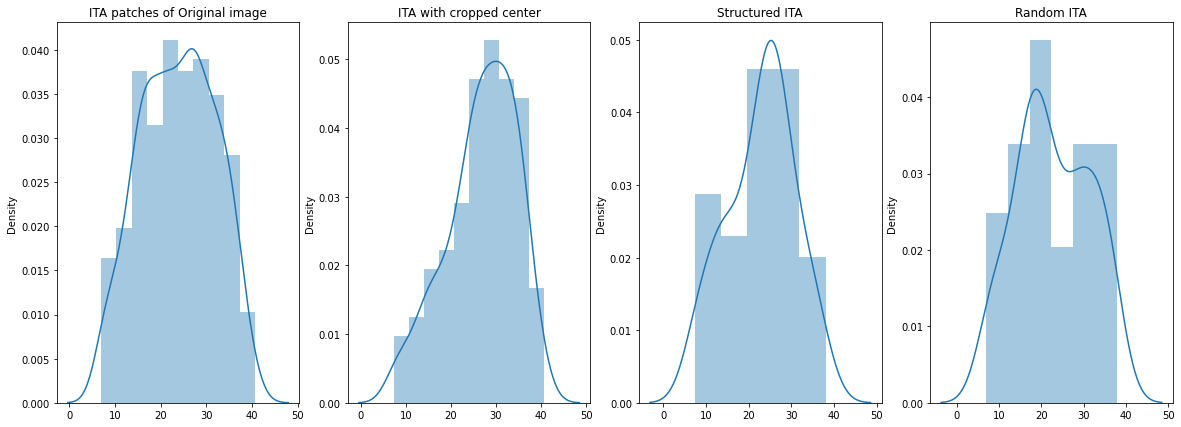

In [192]:
f, axes = plt.subplots(1, 4)
f.set_size_inches(20,7)

ax = sns.distplot(orig_ita_values,ax=axes[0]).set_title("ITA patches of Original image")
ax = sns.distplot(cropped_center_values,ax=axes[1]).set_title("ITA with cropped center")
ax = sns.distplot(structured_ita_values,ax=axes[2]).set_title("Structured ITA")
ax = sns.distplot(random_ita_values,ax=axes[3]).set_title("Random ITA")

## Calculate ITA on all images using following methods

1. Cropped center
2. Structured approach
3. Random patches
4. Smart Random

In [193]:
%%time
%lprun -f get_cropped_center_ita -f get_cropped_center_patches_ita_list -f get_patches -f compute_ita_from_lab df = df.swifter.apply(get_cropped_center_ita, axis=1)

Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 1min 8s, sys: 1.59 s, total: 1min 9s
Wall time: 1min 8s


In [194]:
%%time
%lprun -f get_structured_patches_ita -f get_structured_patches_ita_list -f get_patches -f compute_ita_from_lab df = df.swifter.apply(get_structured_patches_ita, axis=1)

Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 18.3 s, sys: 487 ms, total: 18.8 s
Wall time: 18.4 s


In [195]:
%%time
%lprun -f get_random_patches_ita -f get_random_patches_ita_list -f get_patches -f compute_ita_from_lab df = df.swifter.apply(get_random_patches_ita, axis=1)

Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 26.3 s, sys: 574 ms, total: 26.8 s
Wall time: 26.3 s


## Add the ITA category to the dataframe

In [196]:
"""
This was the original expanding ITA ranges that were used for development. 
It has been deprecated to the 6 ITA categories so that it can be compared to the Groh scale
"""
def add_ita_category(ita):
    if ita <= 10:
        return "dark"
    elif 10 < ita <= 19:
        return "tan1"
    elif 19 < ita <= 28:
        return "tan2"
    elif 28 < ita <= 34.5:
        return "int1"
    elif 34.5 < ita <= 41:
        return "int2"
    elif 41 < ita <= 48:
        return "lt1"
    elif 48 < ita <= 55:
        return "lt2"
    elif 55 < ita:
        return "very_lt"

In [197]:
def add_ita_6_category(ita):
    if ita <= 10:
        return "Type6"
    elif 10 < ita <= 19:
        return "Type5"
    elif 19 < ita <= 28:
        return "Type4"
    elif 28 < ita <= 41:
        return "Type3"
    elif 41 < ita <= 55:
        return "Type2"      
    elif 55 < ita:
        return "Type1"
    else:
        print(f"None cat: {ita}")

In [198]:
%%time
print("orig")
df["ITA_orig_category"] = df["ITA_orig"].swifter.apply(add_ita_6_category)
print("mask")
df["ITA_masked_category"] = df["ITA_masked"].swifter.apply(add_ita_6_category)
print("center")
df["ITA_center_cropped_category"] = df["ITA_center_cropped"].swifter.apply(add_ita_6_category)
print("struct")
df["ITA_structured_patches_category"] = df["ITA_structured_patches"].swifter.apply(add_ita_6_category)
print("rand")
df[f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}_category"] = df[f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}"].swifter.apply(add_ita_6_category)


orig


Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

mask


Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

center


Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

None cat: nan
struct


Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

None cat: nan
None cat: nan
None cat: nan
None cat: nan
None cat: nan
None cat: nan
rand


Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

None cat: nan
CPU times: user 292 ms, sys: 19.3 ms, total: 311 ms
Wall time: 295 ms


## Add the Groh ITA category to dataframe

In [199]:
def add_groh_ita_category(ita):
    if ita <= -25:
        return "Type6"
    elif -25 < ita <= 0:
        return "Type5"
    elif 0 < ita <= 12:
        return "Type4"
    elif 12 < ita <= 23:
        return "Type3"
    elif 23 < ita <= 40:
        return "Type2"      
    elif 40 < ita:
        return "Type1"

In [200]:
%%time
df["ITA_orig_category_groh"] = df["ITA_orig"].swifter.apply(add_groh_ita_category)
df["ITA_masked_category_groh"] = df["ITA_masked"].swifter.apply(add_groh_ita_category)
df["ITA_center_cropped_category_groh"] = df["ITA_center_cropped"].swifter.apply(add_groh_ita_category)
df["ITA_structured_patches_category_groh"] = df["ITA_structured_patches"].swifter.apply(add_groh_ita_category)
df[f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}_category_groh"] = df[f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}"].swifter.apply(add_groh_ita_category)


Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2750 [00:00<?, ?it/s]

CPU times: user 270 ms, sys: 20.4 ms, total: 291 ms
Wall time: 278 ms


# Display images with ITA values

This display will show a sample of 1 image for each category based on the ground truth (masked image ITA value). Along with each image will display each approach with the selected patches and the median ITA value.

CPU times: user 2.83 s, sys: 22.3 ms, total: 2.85 s
Wall time: 2.82 s


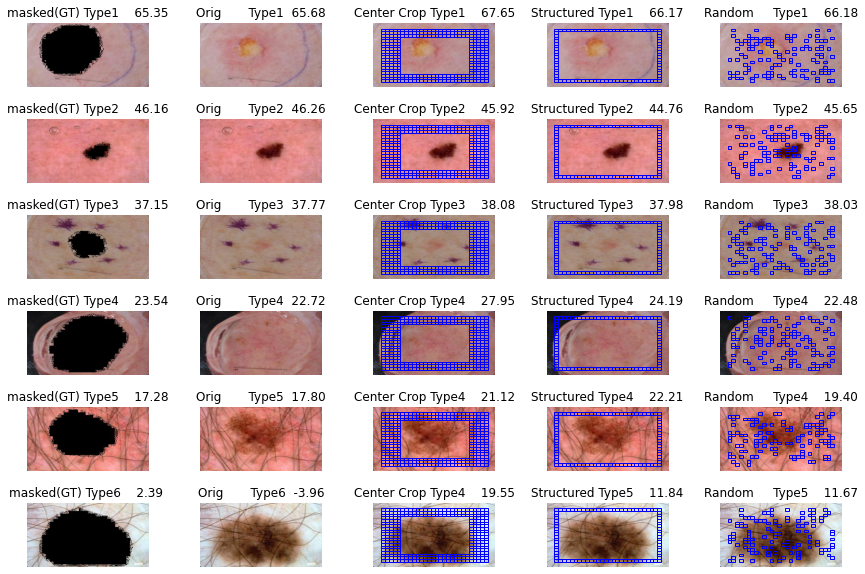

In [201]:
%%time
ITA_Categories_list = ["dark", "tan1", "tan2", "int1", "int2", "lt1", "lt2", "very_lt"]
ITA_Categories_list = ["Type6", "Type5", "Type4", "Type3", "Type2", "Type1"]
ITA_Categories_list.reverse()
        
plt.figure(figsize=(15, 70))
index = 0
display_image_count = 1
col_count = 5
for cat in ITA_Categories_list:
    cat_df = df[df["ITA_masked_category"] == cat]
    #print(cat_df.head())
    for ele in cat_df.head(display_image_count).iterrows():
        #print(ele[1])

        removal_size = get_border_removal_size(Image.open(io.BytesIO(ele[1]["image"])))
        
        # Masked
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["masked_image"])
        plt.imshow(Image.open(img),aspect=.7)        
        title = f"{'masked(GT)':10} {ele[1]['ITA_masked_category']:7}  {ele[1]['ITA_masked']:^5.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)
        index += 1

        # Original
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["image"])
        plt.imshow(Image.open(img),aspect=.7)     
           
        title = f"{'Orig':10} {ele[1]['ITA_orig_category']:7}{ele[1]['ITA_orig']:^3.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)        
        index += 1

        # Center cropped
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["image"])
        plt.imshow(Image.open(img),aspect=.7)        
        title = f"{'Center Crop':10} {ele[1]['ITA_center_cropped_category']:7}  {ele[1]['ITA_center_cropped']:^5.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)            
        coords = ele[1]["ITA_center_cropped_indices"]
        for coord in coords:
            # Create a Rectangle patch    
            x = coord[0] * PATCH_WIDTH + removal_size
            y = int(coord[1] * PATCH_WIDTH) + removal_size    
            rect = mplpatches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
        index += 1

        # Structured
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["image"])
        plt.imshow(Image.open(img),aspect=.7)        
        title = f"{'Structured':10} {ele[1]['ITA_structured_patches_category']:7}  {ele[1]['ITA_structured_patches']:^5.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)
        coords = ele[1]["ITA_structured_patches_indices"]
        for coord in coords:
            # Create a Rectangle patch    
            x = coord[0] * PATCH_WIDTH + removal_size
            y = int(coord[1] * PATCH_WIDTH) + removal_size    
            rect = mplpatches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
        index += 1

        # Random
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["image"])
        plt.imshow(Image.open(img),aspect=.7)        
        title = f"{'Random':10} {ele[1][f'ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}_category']:7}  {ele[1][f'ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}']:^5.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)
        coords = ele[1][f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}_indices"]
        for coord in coords:
            # Create a Rectangle patch    
            x = coord[0] * PATCH_WIDTH + removal_size
            y = int(coord[1] * PATCH_WIDTH) + removal_size    
            rect = mplpatches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
        index += 1

# Evaluate ITA

## Graphs showing the spread between Fitzpatrick and Groh

<Figure size 360x720 with 0 Axes>

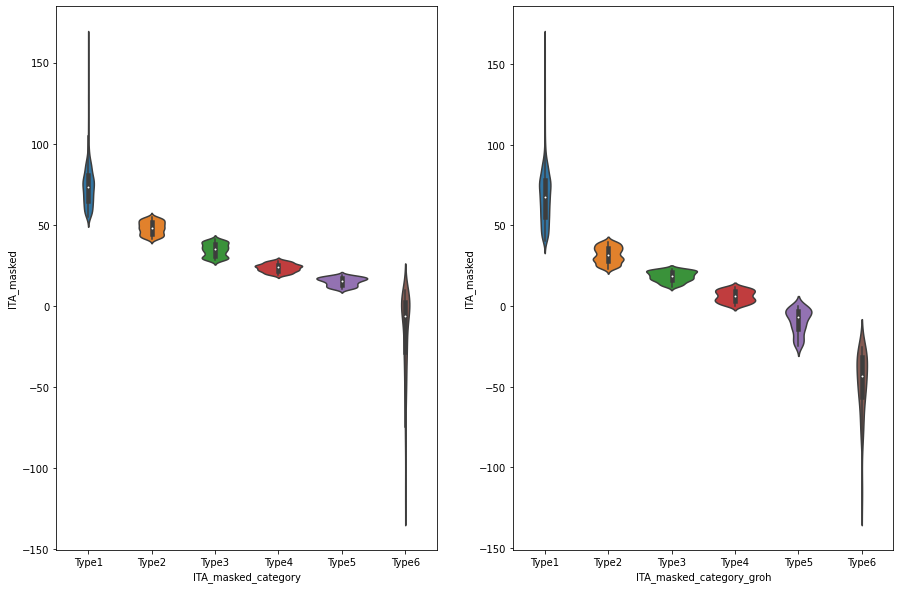

In [202]:
catagories_to_test = ["ITA_orig", "ITA_center_cropped", "ITA_structured_patches", "ITA_random_patches"]
plt.figure(figsize=(5, 10))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ax = sns.violinplot(data=df, y="ITA_masked", x="ITA_masked_category", order=ITA_Categories_list,ax=axes[0])
#ax.set_ylim(-50,100)

ax = sns.violinplot(data=df, y="ITA_masked", x="ITA_masked_category_groh", order=ITA_Categories_list,ax=axes[1])
#ax.set_ylim(-50,100)



Text(0.5, 0.98, 'Comparing Fitzpatrick ranges')

<Figure size 720x720 with 0 Axes>

<Figure size 360x720 with 0 Axes>

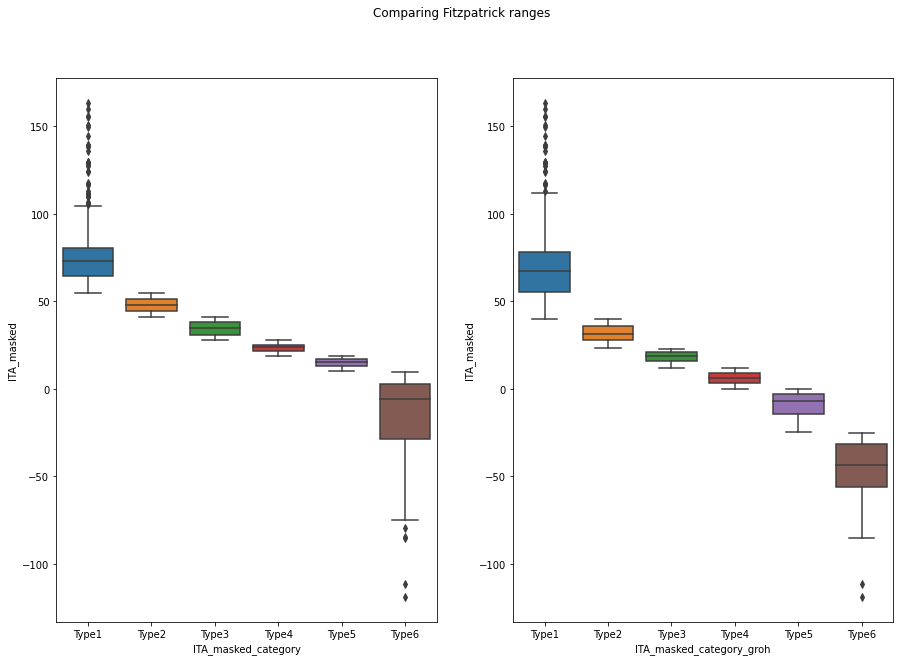

In [203]:
plt.figure(figsize=(10, 10))
plt.figure(figsize=(5, 10))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ax = sns.boxplot(data=df, y="ITA_masked", x="ITA_masked_category", order=ITA_Categories_list,ax=axes[0])
#ax.set_ylim(-120,100)

ax = sns.boxplot(data=df, y="ITA_masked", x="ITA_masked_category_groh", order=ITA_Categories_list,ax=axes[1])
#ax.set_ylim(-120,100)
plt.suptitle("Comparing Fitzpatrick ranges")


<Figure size 1080x720 with 0 Axes>

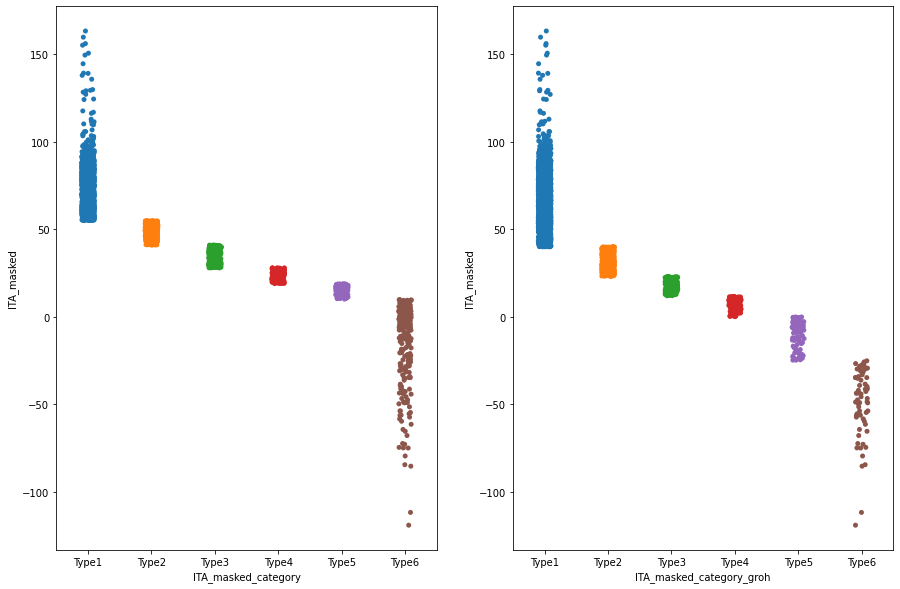

In [204]:
plt.figure(figsize=(15, 10))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ax = sns.stripplot(data=df, y="ITA_masked", x="ITA_masked_category", order=ITA_Categories_list,ax=axes[0])
#ax.set_ylim(-120,100)

ax = sns.stripplot(data=df, y="ITA_masked", x="ITA_masked_category_groh", order=ITA_Categories_list,ax=axes[1])
#ax.set_ylim(-120,100)



## Distribution between skin types for both Fitzpatrick and Groh

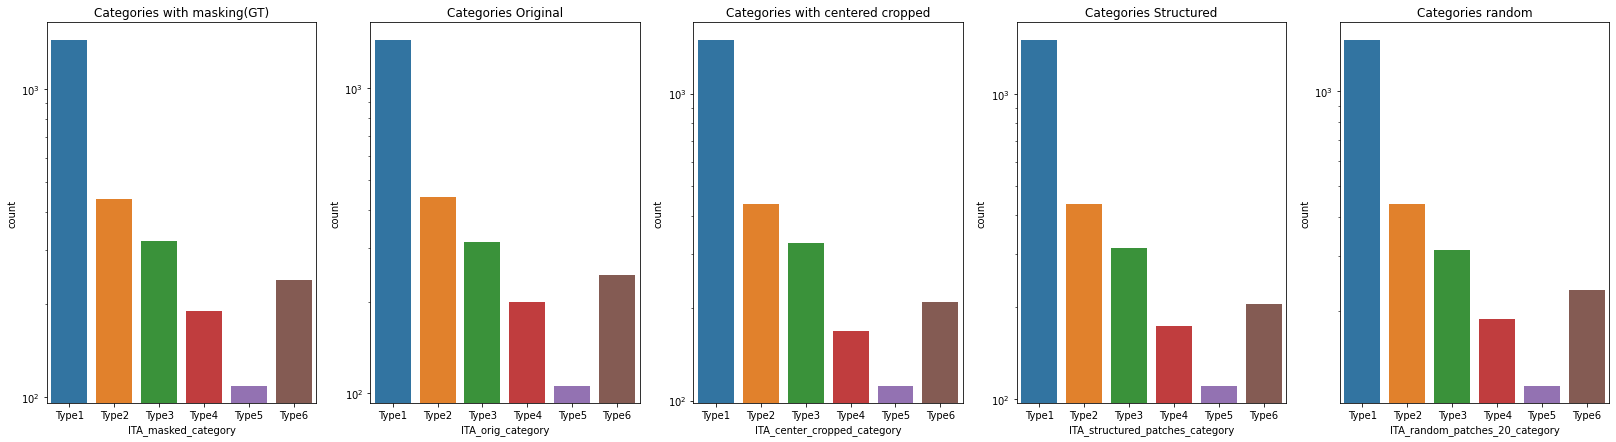

In [205]:
f, axes = plt.subplots(1, 5)
f.set_size_inches(28,7)

ax = sns.countplot(df.ITA_masked_category,ax=axes[0],order=ITA_Categories_list).set_title("Categories with masking(GT)")
ax = sns.countplot(df.ITA_orig_category,ax=axes[1],order=ITA_Categories_list).set_title("Categories Original")
ax = sns.countplot(df.ITA_center_cropped_category,ax=axes[2],order=ITA_Categories_list).set_title("Categories with centered cropped")
ax = sns.countplot(df.ITA_structured_patches_category,ax=axes[3],order=ITA_Categories_list).set_title("Categories Structured")
ax = sns.countplot(df.ITA_random_patches_20_category,ax=axes[4],order=ITA_Categories_list).set_title("Categories random")
for i in range(0,5):
    axes[i].set_yscale('log')

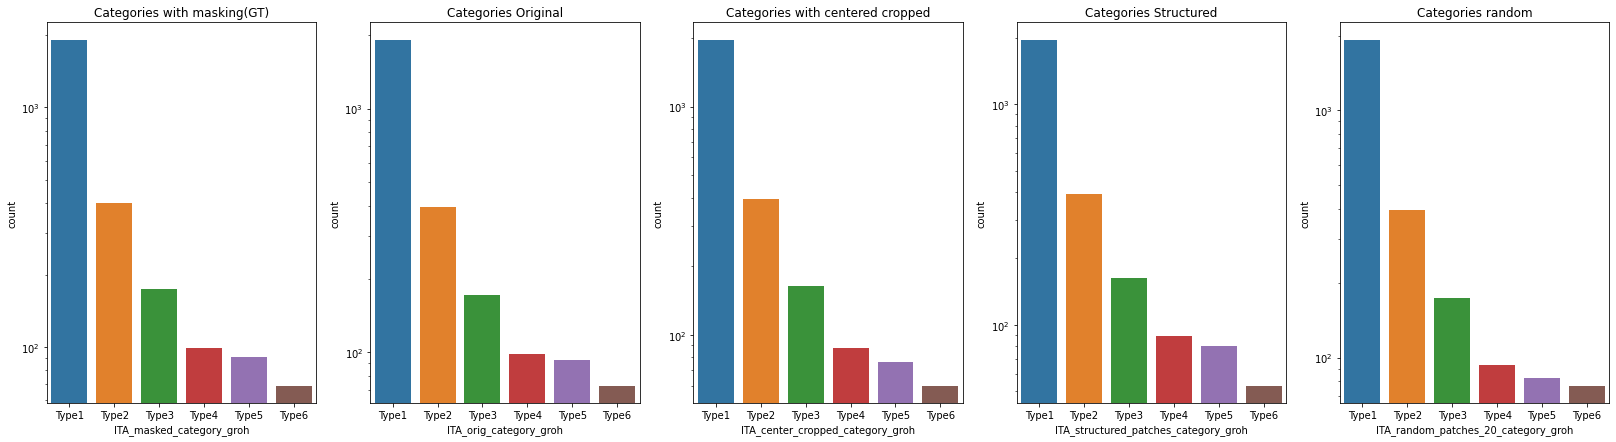

In [206]:
f, axes = plt.subplots(1, 5)
f.set_size_inches(28,7)

ax = sns.countplot(df.ITA_masked_category_groh,ax=axes[0],order=ITA_Categories_list).set_title("Categories with masking(GT)")
ax = sns.countplot(df.ITA_orig_category_groh,ax=axes[1],order=ITA_Categories_list).set_title("Categories Original")
ax = sns.countplot(df.ITA_center_cropped_category_groh,ax=axes[2],order=ITA_Categories_list).set_title("Categories with centered cropped")
ax = sns.countplot(df.ITA_structured_patches_category_groh,ax=axes[3],order=ITA_Categories_list).set_title("Categories Structured")
ax = sns.countplot(df.ITA_random_patches_20_category_groh,ax=axes[4],order=ITA_Categories_list).set_title("Categories random")
for i in range(0,5):
    axes[i].set_yscale('log')

In [207]:
df.describe()

,mask_percentage,ITA_orig,ITA_masked,ITA_center_cropped,ITA_structured_patches,ITA_random_patches_20
count,2750.000000,2750.000000,2750.000000,2749.000000,2744.000000,2749.000000
mean,23.906182,51.684714,51.644782,53.387083,53.674526,51.937864
std,20.624832,31.262660,30.937050,30.068234,29.836008,31.055567
min,1.000000,-113.196940,-118.899784,-95.125121,-106.757459,-104.709033
25%,8.000000,34.024826,34.130733,36.594912,36.687624,34.240154
50%,17.000000,56.903092,56.814839,58.522970,58.670943,57.399863
75%,35.000000,74.374939,74.020178,75.100475,75.047027,74.451968
max,98.000000,159.761448,163.217772,155.223606,155.326562,158.141826


## Performance metrics

Table 3: Evaluation metrics of skin type predictions compared to manually annotated ground-truth. Metrics are  

- RMSE: root mean squared error.
- MAE: mean absolute error

Here is a list of other metrics we can look at https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [208]:
def compute_metrics(df, column, filter_percentage=None):
    results = {}
    df_temp = df
    if filter_percentage is not None:
        df_temp = df_temp[df_temp["mask_percentage"] == filter_percentage]

    
    # drop any NAN rows
    df_temp = df_temp[df_temp[column].notna()]
    df_temp = df_temp[df_temp["ITA_masked"].notna()]    


    results["Root Mean Squared Error"] = mean_squared_error(df_temp.ITA_masked, df_temp[column], squared=False)
    results["Mean Absolute Error"] = mean_absolute_error(df_temp.ITA_masked, df_temp[column])
    #results["Max error"] = max_error(df_temp.ITA_masked, df_temp[column])
    #results["Mean Squared Error"] = mean_squared_error(df_masked_updated, df_column_updated)    
    #results["Explained Variance Score"] = explained_variance_score(df_masked_updated, df_column_updated)
    #results["R^2 Score"] = r2_score(df_masked_updated, df_column_updated)
    
    # Cant do the following because there are negative values in ITA and these metrics dont support negative values
    # 
    #results["Mean Squared Log Error"] = mean_squared_log_error(df_masked_updated, df_column_updated)
    #results["Mean Poisson Deviance"] = mean_poisson_deviance(df_masked_updated, df_column_updated)
    #results["Mean Gamma Deviance"] = mean_gamma_deviance(df_masked_updated, df_column_updated)
    #results["Mean Tweedie Deviance"] = mean_tweedie_deviance(df_masked_updated, df_column_updated)

    return results

In [209]:
# evaluating using mean squared error
# as part of the ITA calculation some rows could not compute the ITA value. 
# We will do some preprocess to drop those rows
catagories_to_test = ["ITA_orig", "ITA_center_cropped", "ITA_structured_patches",
                      f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}"]

printed_header = False
for cat in catagories_to_test:
    results = compute_metrics(df,cat)
    if not printed_header:
        print_str = f"|{'Approach':^25}|"
        for key, val in results.items():
            print_str +=f"{key:^25}|"
        print(print_str)
        printed_header = True

    print_str = f"|{cat:25}|"
    for key, val in results.items():
        print_str += f"{val:^25.3f}|"
    print(print_str)


|        Approach         | Root Mean Squared Error |   Mean Absolute Error   |
|ITA_orig                 |          2.045          |          0.856          |
|ITA_center_cropped       |          6.547          |          2.312          |
|ITA_structured_patches   |          7.618          |          3.066          |
|ITA_random_patches_20    |          3.906          |          1.523          |


## Compare the lesion size vs error
This section will go over comparing the lesion size which will be made up from taking the count of the masked pixels and comparing that to the total count of pixels to come up with a percentage. This percentage will be used to compare the error to see how the lesion size might affect the ITA computations



In [210]:
# compute the error
catagories_to_test = ["ITA_orig", "ITA_center_cropped", "ITA_structured_patches",
                      f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}"]

verobose_logging = False
printed_header = False
# Get list of percentages
percentage = df.mask_percentage.unique()
percentage.sort()
if verobose_logging:
    print(percentage)
results_list = []
for p in percentage:
    if verobose_logging:
        print(f"--{p}--")
    for cat in catagories_to_test:
        try:
            results = compute_metrics(df,cat,p)
            if not printed_header:
                print_str = f"|{'Approach':^25}|"
                for key, val in results.items():
                    print_str +=f"{key:^25}|"
                if verobose_logging:
                    print(print_str)
                printed_header = True
            
            current_result = [cat,p]
            print_str = f"|{cat:25}|"
            for key, val in results.items():
                print_str += f"{val:^25.3f}|"
                current_result.append(val)
            if verobose_logging:
                print(print_str)
            results_list.append(current_result)
        except:
            if verobose_logging:
                print("Compute_metrics probably had a issue with an nan")


df_metrics_on_percentage = pd.DataFrame(data=results_list, columns=["approach","percentage", "root_mean_squared_error", "mean_absolute_error"])

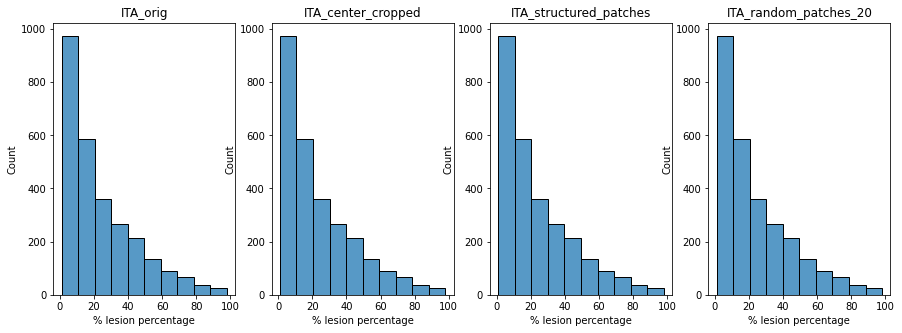

In [211]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
#f, axes = plt.subplots(1, 4)

x = 0
for cat in catagories_to_test:        
    ax = sns.histplot(data=df.mask_percentage, ax=axes[x],bins=10)
    #ax = df_appraoch.plot.hist(x="percentage",y="root_mean_squared_error" , alpha=.5, bins=100)
    ax.set_title(cat)
    ax.set_xlabel("% lesion percentage")
    x += 1
    y += 1

### Distribution over skin type

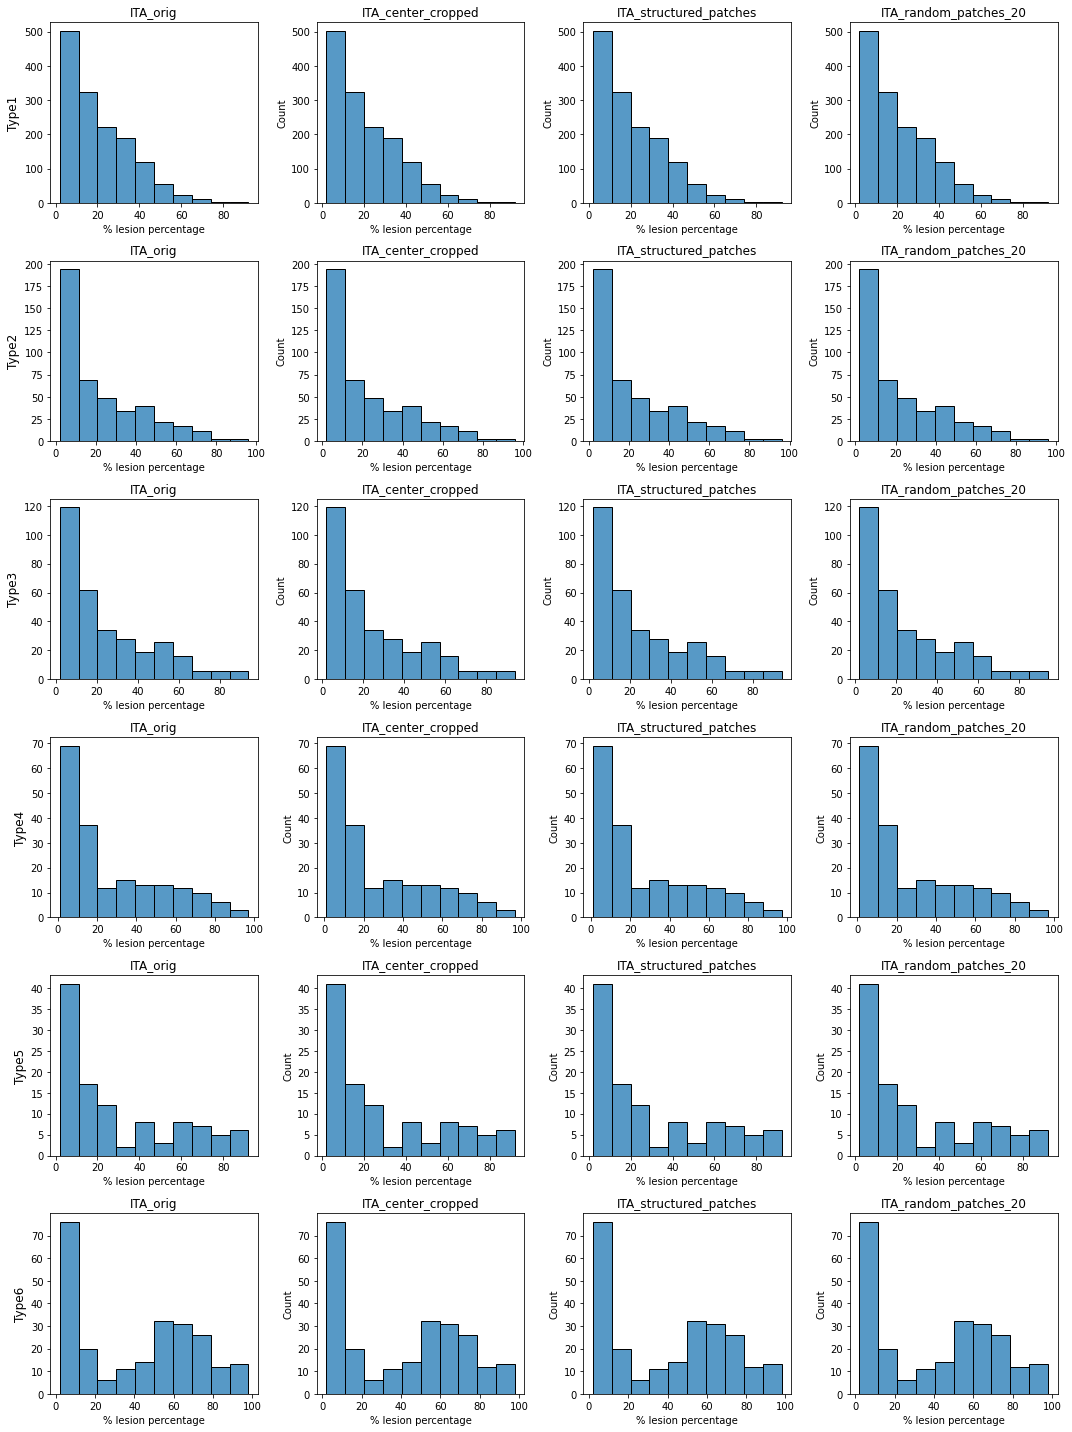

In [212]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15,20))
#f, axes = plt.subplots(1, 4)

y = 0
for skin_type in ITA_Categories_list:
    x = 0    
    for cat in catagories_to_test:    
        df_skin_filtered = df[df.ITA_masked_category == skin_type]
        ax = sns.histplot(data=df_skin_filtered.mask_percentage, ax=axes[y,x],bins=10)
        #ax = df_appraoch.plot.hist(x="percentage",y="root_mean_squared_error" , alpha=.5, bins=100)
        ax.set_title(cat)
        ax.set_xlabel("% lesion percentage")
        x += 1
    y += 1
for ax, row in zip(axes[: , 0], ITA_Categories_list):
   ax.set_ylabel(row, rotation = 90, size = 'large')
    
plt.tight_layout()
plt.show()

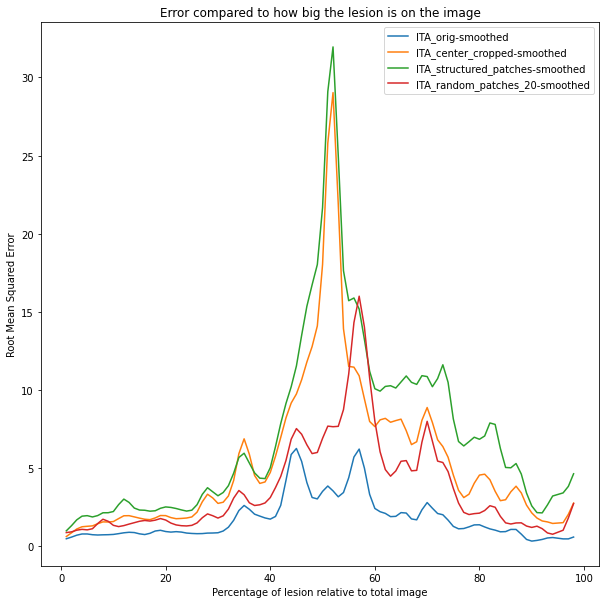

In [213]:
fig = plt.figure(figsize=(10, 10))

x_new = np.linspace(1, 100, 100)

for cat in catagories_to_test:
    df_appraoch = df_metrics_on_percentage[df_metrics_on_percentage['approach']==cat]
    ysmoothed = gaussian_filter1d(df_appraoch.root_mean_squared_error, sigma=1.2)
    plt.plot(df_appraoch.percentage, ysmoothed, label=f"{cat}-smoothed")
    
plt.xlabel("Percentage of lesion relative to total image")
plt.ylabel("Root Mean Squared Error")
plt.title("Error compared to how big the lesion is on the image")
plt.legend(loc='best')
plt.show()

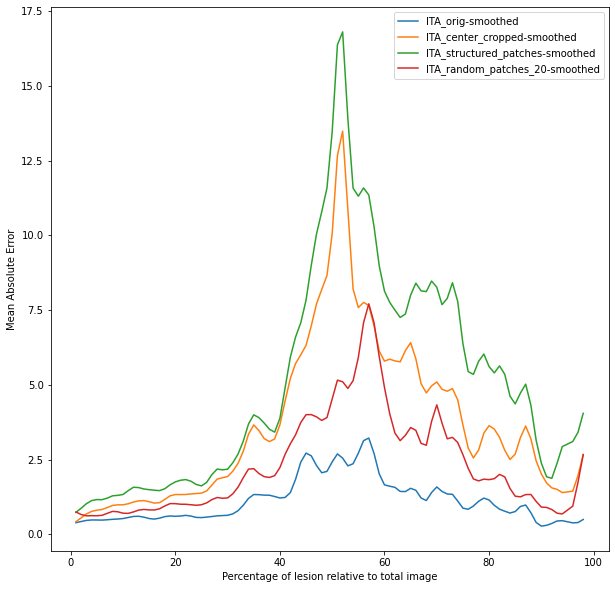

In [214]:
plt.figure(figsize=(10, 10))
x_new = np.linspace(1, 100, 100)

for cat in catagories_to_test:
    df_appraoch = df_metrics_on_percentage[df_metrics_on_percentage['approach']==cat]
    ysmoothed = gaussian_filter1d(df_appraoch.mean_absolute_error, sigma=1.2)
    plt.plot(df_appraoch.percentage, ysmoothed, label=f"{cat}-smoothed")

plt.xlabel("Percentage of lesion relative to total image")
plt.ylabel("Mean Absolute Error")
# plt.title("Error compared to how big the lesion is on the image")
plt.legend(loc='best')
plt.show()

## Classification performance

### Classification metrics

In [215]:
from sklearn import metrics
for index, cat in enumerate(catagories_to_test*2):
    
    category = f"{cat}_category"    
    masked_cat = "ITA_masked_category"
    # setting Groh sections
    if index >3:
        category += "_groh"
        masked_cat += "_groh"

    #print(category, masked_cat)
    df_temp = df[df[category].notna()]
    df_temp = df_temp[df_temp[masked_cat].notna()]
    print(category)
    print(classification_report(df_temp[masked_cat],df_temp[category]))
    print("hamming_loss", hamming_loss(df_temp[masked_cat],df_temp[category]))    
    print("---------------")

ITA_orig_category
              precision    recall  f1-score   support

       Type1       0.99      0.99      0.99      1449
       Type2       0.95      0.95      0.95       439
       Type3       0.93      0.91      0.92       322
       Type4       0.90      0.95      0.93       190
       Type5       0.94      0.92      0.93       109
       Type6       0.98      0.99      0.98       241

    accuracy                           0.97      2750
   macro avg       0.95      0.95      0.95      2750
weighted avg       0.97      0.97      0.97      2750

hamming_loss 0.030545454545454546
---------------
ITA_center_cropped_category
              precision    recall  f1-score   support

       Type1       0.96      1.00      0.98      1448
       Type2       0.87      0.86      0.87       439
       Type3       0.82      0.83      0.82       322
       Type4       0.82      0.73      0.77       190
       Type5       0.76      0.78      0.77       109
       Type6       1.00      0.86   

### Confusion matrix of labels

<Figure size 504x504 with 0 Axes>

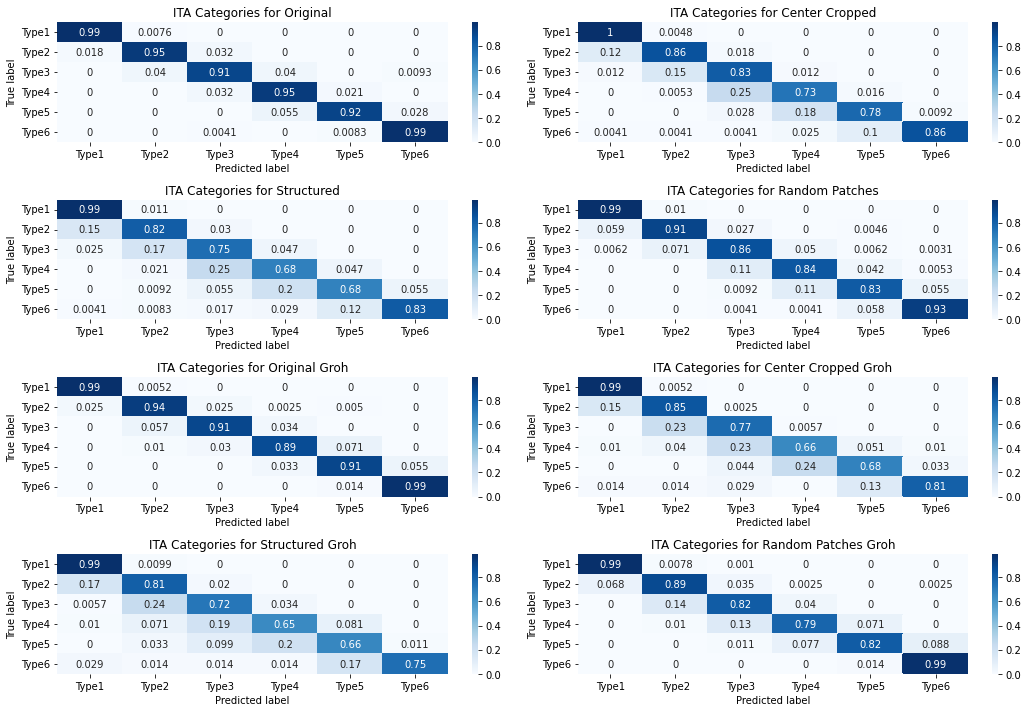

In [216]:
plt.figure(figsize=(7, 7))
cols = 2
rows = 4
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,10))

plot_titles = ["ITA Categories for Original", "ITA Categories for Center Cropped", "ITA Categories for Structured", "ITA Categories for Random Patches",
               "ITA Categories for Original Groh", "ITA Categories for Center Cropped Groh", "ITA Categories for Structured Groh", "ITA Categories for Random Patches Groh"]

for index, cat in enumerate(catagories_to_test*2):
    
    category = f"{cat}_category"    
    masked_cat = "ITA_masked_category"
    # setting Groh sections
    if index >3:
        category += "_groh"
        masked_cat += "_groh"

    #print(category, masked_cat)
    df_temp = df[df[category].notna()]
    df_temp = df_temp[df_temp[masked_cat].notna()]
    

    cm = confusion_matrix(df_temp[masked_cat],df_temp[category],normalize="true")
    df_cm = pd.DataFrame(cm,columns=np.unique(df_temp[masked_cat].to_numpy()),index=np.unique(df_temp[masked_cat].to_numpy()))
    row = index % cols
    col = int(index/cols)
    ax = sns.heatmap(df_cm, annot=True,cmap="Blues",ax=axes[col,row])
    ax.set_title(plot_titles[index])
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
plt.tight_layout()
